This notebook organizes all the results in the "analysis" folder within a concrete storyline

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is converted to HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_read_parsing import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from patsy import dmatrices
# from scipy.stats import ranksums
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.graphics.api import interaction_plot, abline_plot
# from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit

%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 7, 4
pd.set_option('precision',3)
pd.set_option("display.width", 100)
pd.set_option("max.columns", 100)
np.set_printoptions(precision=3,suppress=True)

# Preparing the data
We wish to have a table that looks like:

In [3]:
t = [['sid','sim','variable','pre','main','CVS_table','CVS_graph','tansfer_qual','tansfer_quant','attributes']]
t.append(['12345678','C','Width',1,2,1,1,1,0,'...'])
t.append(['12345678','C','Concentration',2,3,1,1,1,1,'...'])
t.append(['12345678','C','Area',1,2,1,0,1,0,'...'])
print tabulate(t)

--------  ---  -------------  ---  ----  ---------  ---------  ------------  -------------  ----------
sid       sim  variable       pre  main  CVS_table  CVS_graph  tansfer_qual  tansfer_quant  attributes
12345678  C    Width          1    2     1          1          1             0              ...
12345678  C    Concentration  2    3     1          1          1             1              ...
12345678  C    Area           1    2     1          0          1             0              ...
--------  ---  -------------  ---  ----  ---------  ---------  ------------  -------------  ----------


## Defining important variables

In [4]:
ids = get_students_to_analyze_log()
N = len(ids)
print "There are {0} students to analyze.".format(N)

There are 148 students to analyze.


In [5]:
variables = ["Area","Separation","Width","Concentration"]
print "We are analyzing student knowledge and modeling of these variables: {0}.".format(', '.join(variables))

We are analyzing student knowledge and modeling of these variables: Area, Separation, Width, Concentration.


In [6]:
merged = True
number_of_trials = 3
if merged:
    print '''We will be analyzing cvs where table_consecutive and table_non_consecutive are merged
        and CVS is detected for {0} minimum trials.'''.format(number_of_trials)
else:
    print '''We will be analyzing cvs where table_consecutive and table_non_consecutive are NOT merged
        and CVS is detected for {0} minimum trials.'''.format(number_of_trials)

We will be analyzing cvs where table_consecutive and table_non_consecutive are merged
        and CVS is detected for 3 minimum trials.


## Loading all student data files

In [7]:
%reload_ext utils_read_parsing
meta_df = get_student_metadata()
pre_survey_df = get_massaged_pre_survey()
post_survey_df = get_massaged_post_survey()
attitudes_df = get_incoming_attitudes()
worksheet_df = get_massaged_worksheet_highest_understanding_data()
cvs_df = get_cvs_results(number_of_trials,merged=merged)
transfer_df = get_massaged_near_transfer_data()
wrapper_use_df = get_use_wrapper_results().rename(columns={'studentid':'sid'})

In [8]:
#We only keep the worksheet data,CVS and transfer data for the variables we care about
worksheet_df = worksheet_df[worksheet_df['variable'].isin(variables)]
cvs_df = cvs_df[cvs_df['variable'].isin(variables)]
transfer_df = transfer_df[transfer_df['variable'].isin(variables)]

Here are the dataframes and their sizes:

In [9]:
print "meta", meta_df.shape
print "pre_survey", pre_survey_df.shape
print "post_survey", post_survey_df.shape
print "worksheet", worksheet_df.shape
print "cvs", cvs_df.shape
print "transfer", transfer_df.shape
print "wrapper_use", wrapper_use_df.shape

meta (180, 23)
pre_survey (148, 24)
post_survey (296, 70)
worksheet (592, 5)
cvs (592, 3)
transfer (592, 4)
wrapper_use (148, 7)


## Putting it all together
The worksheet dataframe is the most complex with 1 row for each combination of sid * variable * model so we merge other data onto it.

In [75]:
data = worksheet_df.copy()
data = data.merge(cvs_df, how='outer', on=['sid','variable']);
data = data.merge(transfer_df, how='outer', on=['sid','variable']);
data = data.merge(wrapper_use_df, how='outer', on=['sid']);

In [76]:
set(data['CVS_context'])

{0L, 1L, 2L}

In [77]:
## We add the student activity order
order = dict(zip(meta_df.index,meta_df['activity order']))
data['activity_order'] = data.sid.apply(lambda sid: order[sid])
data['sim_index'] = data.apply(lambda row: row['activity_order'].index(row['sim'])+1,axis=1)

We would like to use following student attributes from pre surveys in our stats models:
* level of physics and chemistry lab experience
* level of virtual lab experience
* if they have used a similar sim before
* perception of competence and control
* task interpretation
* perceived value

In [78]:
student_data_L = pd.DataFrame({'sid':ids,'sim':'L','similar_sim':0})
student_data_C = pd.DataFrame({'sid':ids,'sim':'C','similar_sim':0})

pre_survey_df['similar_same_L'] = (pre_survey_df['similar_L'] + pre_survey_df['same_L']).replace(2,1)
pre_survey_df['similar_same_C'] = (pre_survey_df['similar_C'] + pre_survey_df['same_C']).replace(2,1)

similar_same_L = dict(zip(pre_survey_df['sid'],pre_survey_df['similar_same_L']))
similar_same_C = dict(zip(pre_survey_df['sid'],pre_survey_df['similar_same_C']))

student_data_L['similar_sim'] = student_data_L['sid'].apply(lambda sid: similar_same_L[sid])
student_data_C['similar_sim'] = student_data_C['sid'].apply(lambda sid: similar_same_C[sid])

student_data = pd.concat([student_data_L,student_data_C],axis=0).reset_index(drop=True)

In [79]:
lab_columns = ['[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory]','[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory]','[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs]']
pre_survey_df['lab_experience'] = pre_survey_df[lab_columns].fillna(0).sum(axis=1).replace(3,1).replace(2,1)
student_data = student_data.merge(pre_survey_df[['sid','lab_experience','prior_number_virtual_labs']], how="inner", on=['sid']);
student_data = student_data.merge(attitudes_df, how="inner", on=['sid']);

In [80]:
data = data.merge(student_data, how="inner", on = ['sid','sim'])

And here is what are data for 1 student looks like:

In [81]:
data.sort_values(['sid','variable']).reset_index(drop=True).head(12)

,sid,variable,pre_highest,sim,main_highest,CVS_context,qual_score,quant_score,use_table,use_graph,use_concentration,use_width,use_area,use_separation,activity_order,sim_index,similar_sim,lab_experience,prior_number_virtual_labs,overall POCC,PC1,PC2
0,10127163,Area,3.0,C,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,2,0,1.0,1,17,-0.509,0.152
1,10127163,Concentration,1.0,L,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,0,1.0,1,17,-0.509,0.152
2,10127163,Separation,3.0,C,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,2,0,1.0,1,17,-0.509,0.152
3,10127163,Width,1.0,L,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,0,1.0,1,17,-0.509,0.152
4,10192168,Area,1.0,C,2.0,0,0.0,0.0,1,1,1,1,1,1,CL,1,0,1.0,1,15,1.259,0.029
5,10192168,Concentration,1.0,L,3.0,2,1.0,0.0,1,1,1,1,1,1,CL,2,0,1.0,1,15,1.259,0.029
6,10192168,Separation,1.0,C,2.0,2,0.0,0.0,1,1,1,1,1,1,CL,1,0,1.0,1,15,1.259,0.029
7,10192168,Width,1.0,L,0.0,1,1.0,0.0,1,1,1,1,1,1,CL,2,0,1.0,1,15,1.259,0.029
8,10232160,Area,1.0,C,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,2,0,1.0,1,15,1.034,-0.283
9,10232160,Concentration,1.0,L,1.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,1,1.0,1,15,1.034,-0.283


## Massaging data for stats models
1. We remove the student who didn't engage with the charge sim.
* we don't care about "identify" so we turn scores of 1 to 0, 2->1 (qual) and 3->2 (quant).
* We split CVS_context to graph and table

In [82]:
data['use_all_vars'] = data['use_concentration'] + data['use_width'] + data['use_area'] + data['use_separation']
for student_to_remove in list(set(data[data['use_all_vars']<4]['sid'])):
    data = data[data['sid']!=student_to_remove];
N = len(set(data['sid']))
N

147

In [83]:
data['pre'] = data['pre_highest'].replace(1,0).replace(2,1).replace(3,2)
data['main'] = data['main_highest'].replace(1,0).replace(2,1).replace(3,2)
data.rename({'pre_highest':'pre_with_ident','main_highest':'main_with_ident'},inplace=True,axis=1)
data.head()

,sid,variable,pre_with_ident,sim,main_with_ident,CVS_context,qual_score,quant_score,use_table,use_graph,use_concentration,use_width,use_area,use_separation,activity_order,sim_index,similar_sim,lab_experience,prior_number_virtual_labs,overall POCC,PC1,PC2,use_all_vars,pre,main
0,10127163,Concentration,1.0,L,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,0,1.0,1,17,-0.509,0.152,4,0.0,2.0
1,10127163,Width,1.0,L,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,0,1.0,1,17,-0.509,0.152,4,0.0,2.0
2,10127163,Area,3.0,C,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,2,0,1.0,1,17,-0.509,0.152,4,2.0,2.0
3,10127163,Separation,3.0,C,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,2,0,1.0,1,17,-0.509,0.152,4,2.0,2.0
4,10232160,Concentration,1.0,L,1.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,1,1.0,1,15,1.034,-0.283,4,0.0,0.0


In [84]:
data['cvs_graph'] = data['CVS_context'].replace(1,0).replace(2,1)
data['cvs_table'] = data['CVS_context'].replace(2,1)

## Exporting the data

In [85]:
export_data = data.copy()
export_data.to_csv(os.path.join(BIG_FOLDER,'all_massaged_data\\dataframe_all_factors_for_analysis.txt'), sep='\t', index=False)

## Stats tools

In [86]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def clean_summary(model):
    m = model.summary()
    lines = m.as_text().split('\n')
    lines = [l for l in lines if 'C(sid)' not in l]
    return '\n'.join(lines)

# Results to present in methods
## Student population

In [87]:
genders = ['gender-Gender non conforming/non-binary','gender-Man','gender-Prefer not to answer','gender-Woman']
t = [['Gender identity','Number of students','Percentage']]
for g in genders:
    t.append([g, len(set(post_survey_df[post_survey_df[g]==1]['sid'])), round(len(set(post_survey_df[post_survey_df[g]==1]['sid']))/float(N)*100,1)])
print tabulate(t)

---------------------------------------  ------------------  ----------
Gender identity                          Number of students  Percentage
gender-Gender non conforming/non-binary  1                   0.7
gender-Man                               50                  34.0
gender-Prefer not to answer              1                   0.7
gender-Woman                             96                  65.3
---------------------------------------  ------------------  ----------


In [88]:
years = ['year-1st year undergraduate','year-2nd year undergraduate','year-3rd year undergraduate','year-4th year undergraduate']
t = [['Year','Number of students','Percentage']]
for year in years:
    t.append([year, len(set(post_survey_df[post_survey_df[year]==1]['sid'])), round(len(set(post_survey_df[post_survey_df[year]==1]['sid']))/float(N)*100,1)])
print tabulate(t)

---------------------------  ------------------  ----------
Year                         Number of students  Percentage
year-1st year undergraduate  112                 76.2
year-2nd year undergraduate  22                  15.0
year-3rd year undergraduate  11                  7.5
year-4th year undergraduate  4                   2.7
---------------------------  ------------------  ----------


In [89]:
post_survey_df['english.0-writing'].value_counts()

Fluent      134
Average      13
Beginner      1
Name: english.0-writing, dtype: int64

In [90]:
post_survey_df['english.1-reading'].value_counts()#.plot.bar()

Fluent     137
Average     11
Name: english.1-reading, dtype: int64

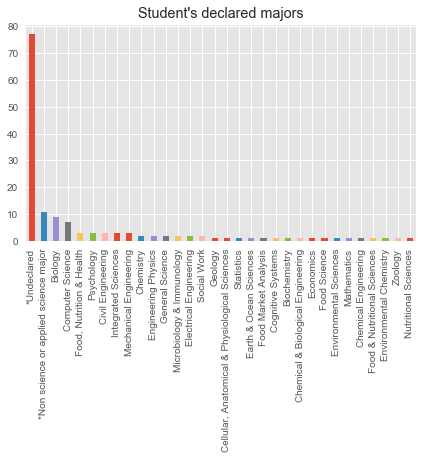

In [91]:
post_survey_df['major'].value_counts().plot.bar()
plt.title('Student\'s declared majors');

## Student prior experience

In [92]:
print "{0} ({1}%) of students have prior physics or chemistry experience.".format(len(set(data[data['lab_experience']==1]['sid'])), round(float(len(set(data[data['lab_experience']==1]['sid'])))/float(N),3)*100)
print "{0} ({1}%) of students have prior experience with the same or a similar sim as the Light absorbance sim.".format(len(set(data[(data['sim']=='L')&(data['similar_sim']==1)]['sid'])), round(float(len(set(data[(data['sim']=='L')&(data['similar_sim']==1)]['sid'])))/float(N),3)*100)
print "{0} ({1}%) of students have prior experience with the same or a similar sim as the Charge sim.".format(len(set(data[(data['sim']=='C')&(data['similar_sim']==1)]['sid'])), round(float(len(set(data[(data['sim']=='C')&(data['similar_sim']==1)]['sid'])))/float(N),3)*100)

132 (89.8%) of students have prior physics or chemistry experience.
55 (37.4%) of students have prior experience with the same or a similar sim as the Light absorbance sim.
16 (10.9%) of students have prior experience with the same or a similar sim as the Charge sim.


In [93]:
priors = list(set(data['prior_number_virtual_labs']))
t = [['Number of prior virtual labs','Number of students','Percentage']]
for prior in priors:
    t.append([prior, len(set(data[data['prior_number_virtual_labs']==prior]['sid'])), round(len(set(data[data['prior_number_virtual_labs']==prior]['sid']))/float(N)*100,1)])
print tabulate(t)
print '''where:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)'''

----------------------------  ------------------  ----------
Number of prior virtual labs  Number of students  Percentage
0                             14                  9.5
1                             38                  25.9
2                             55                  37.4
3                             40                  27.2
----------------------------  ------------------  ----------
where:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)


In [94]:
print "In terms of activity order, {0} students do LC and {1} students in CL".format(len(set(data[data['activity_order']=='LC']['sid'])),len(set(data[data['activity_order']=='CL']['sid'])))

In terms of activity order, 76 students do LC and 71 students in CL


## Defining incoming attitude factors
See the notebook "incoming_attributes_analysis.ipynb" for data and viz on that.

# Results section
## Learning through inquiry

Let's look at pre to post to see if students learn.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000164F0C18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000016184A20>]], dtype=object)

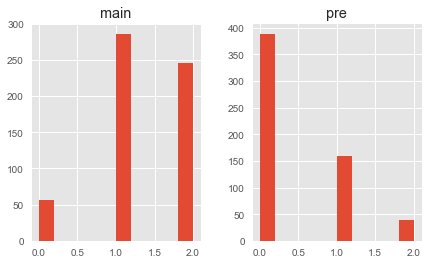

In [95]:
data[['pre','main']].hist()

In [96]:
data.head()

,sid,variable,pre_with_ident,sim,main_with_ident,CVS_context,qual_score,quant_score,use_table,use_graph,use_concentration,use_width,use_area,use_separation,activity_order,sim_index,similar_sim,lab_experience,prior_number_virtual_labs,overall POCC,PC1,PC2,use_all_vars,pre,main,cvs_graph,cvs_table
0,10127163,Concentration,1.0,L,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,0,1.0,1,17,-0.509,0.152,4,0.0,2.0,1,1
1,10127163,Width,1.0,L,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,0,1.0,1,17,-0.509,0.152,4,0.0,2.0,1,1
2,10127163,Area,3.0,C,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,2,0,1.0,1,17,-0.509,0.152,4,2.0,2.0,1,1
3,10127163,Separation,3.0,C,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,2,0,1.0,1,17,-0.509,0.152,4,2.0,2.0,1,1
4,10232160,Concentration,1.0,L,1.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,1,1.0,1,15,1.034,-0.283,4,0.0,0.0,1,1


In [97]:
table = data.melt(value_vars=['pre','main'],id_vars=['sid','variable'],var_name='type')
table.groupby(['type','value']).count()

sid  variable
type value               
main 0.0     56        56
     1.0    286       286
     2.0    246       246
pre  0.0    389       389
     1.0    160       160
     2.0     39        39

In [98]:
table = pd.pivot_table(data, index=['variable'], values=['pre','main'],aggfunc=(np.sum))/N
# # table['pre_correct'] = table['pre_correct']/table['pre_statement']*100
# table['main_correct'] = table['main_correct']/table['main_statement']*100
# table = table.round(1)
# sns.heatmap(table[['pre_statement','main_statement']],annot=True,vmin=0, vmax=100)
# plt.title("Average percentage of students making a statement for each model type for a variable")

In [99]:
table

,main,pre
variable,,
Area,1.327,0.415
Concentration,1.395,0.429
Separation,1.218,0.463
Width,1.354,0.313


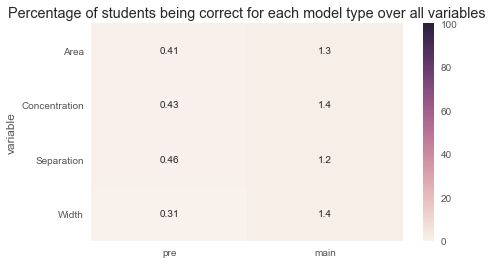

In [100]:
sns.heatmap(table[['pre','main']],annot=True,vmin=0, vmax=100)
plt.title("Percentage of students being correct for each model type over all variables")

## Use of CVS and thus how to define it.
See the notebook "comparing_cvs_usage.ipynb" for data and viz on that.

## Using different levels of CVS and modelling

For each type of model (qual and quant), we have 10 independant variables:
* sim_index (wither it was students 1st or 2nd activity)
* variable (thus don't include sim)
* CVS_context (type of CVS done)
* pre_statement (if model statement made in pre)
* pre_correct (if statement is correct in pre)
* student attributes: lab_experience, similar_sim, prior_number_virtual_labs

And 3 dependant:
* main_statement
* main_correct


### Descriptives

In [104]:
# subdata = data[data['cvs_table']==0]
# subdata = subdata[subdata['variable']=='Width']
# subdata.head()
# print subdata.shape[0]
table = data.melt(value_vars=['pre','main'],id_vars=['sid','variable','CVS_context'],var_name='type')
table = table.groupby(['CVS_context','variable','type','value']).count()

In [109]:
table = table.unstack()#..unstack()#plot.barh(ax=ax,colors=['cornflowerblue','darkblue'],stacked=True)

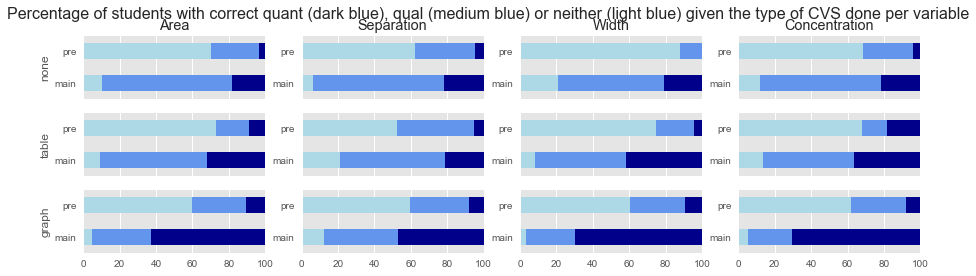

In [134]:
table = data.melt(value_vars=['pre','main'],id_vars=['sid','variable','CVS_context'],var_name='type')
table = table.groupby(['CVS_context','variable','type','value']).count()

fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(15,4))
for j,var in enumerate(variables):
    for i,cvs in enumerate([0,1,2]):
        ax=axes[i,j]
        subdata = table.loc[(cvs,var)]
        N_CVS = subdata['sid'].sum()
        subdata['precent students'] = subdata['sid']/N_CVS*2*100
        subdata['precent students'].unstack().plot.barh(ax=ax,colors=['lightblue','cornflowerblue','darkblue'],stacked=True)
        if i==0:
            ax.set(title=var)
        ax.set(xlabel='')
        if j==0:
            ax.set(ylabel={0:"none",1:"table",2:"graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        ax.set(xlim=(0,100))
        ax.legend([])
plt.suptitle('Percentage of students with correct quant (dark blue), qual (medium blue) or neither (light blue) given the type of CVS done per variable', fontsize=16)

In [ ]:
fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(15,4))
for j,var in enumerate(variables):
    for i,cvs in enumerate([0,1,2]):
        ax=axes[i,j]
        subdata = table.loc[(cvs,var)]
        N_CVS = subdata.shape[0]
        subdata.plot.barh(ax=ax,colors=['lightblue','cornflowerblue','darkblue'],stacked=True)
        if i==0:
            ax.set(title=var)
        ax.set(xlabel='')
        if j==0:
            ax.set(ylabel={0:"none",1:"table",2:"graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
#         ax.set(xlim=(0,100))
plt.suptitle('This is a somewhat long figure title', fontsize=16)

In [ ]:
table = pd.pivot_table(data, index=['variable','CVS_context'], values=['quant_score'],aggfunc=(np.sum,'count'))
table = table/3.0
table['percent correct'] = table.quant_score['sum'] / table.quant_score['count']*100
table = table.round(2)
print "Number of student*variable instances if student did cvs"
sns.heatmap(table,annot=True,vmin=0, vmax=100)
table

### Filtering data
**Unlike before, we don't remove students with max pre for a certain variables???**
However let's look at how many students play with the variables, table and graph

In [ ]:
print 'The number of students out of {0} to use each item at least once:'.format(N)
data[[c for c in data.columns if 'use' in c]].sum()/12

Everyone uses table but not graph. One student doesn't play with separation or area so **do we want to remove those rows (but keep the student's other data)???**


https://www.marsja.se/repeated-measures-anova-using-python/

### What is associated with students making a correct qualitative assessment?
Controlling for the fact that students made a qualitative statement about that variable in the pre worksheet or not (regardless of correctness) we predict that a student made a correct qualitative statement in their main (versus making an incorrect or not making a qual statement at all).

In [ ]:
# independant_variables_for_model = " C(CVS_context) + variable + pre_statement + sim_index + lab_experience + similar_sim + prior_number_virtual_labs"

In [ ]:
# formula = 'main_correct ~ '+ independant_variables_for_model
# print ' model: ', formula,'\n'
# Y, X = dmatrices(formula, data.dropna(axis=0, how='any'), return_type = 'dataframe')
# logit = Logit(Y, X)
# model = logit.fit()
# print model.summary()

In [ ]:
# for model_type in ['qual','quant']:#sorted(list(set(data['model']))):
#     model_data = data[data['model']==model_type]
#     model_data.dropna(subset = ['main_correct'], inplace=True)
#     print model_data.shape
#     formula = 'main_correct ~ '+ independant_variables_for_model
#     print model_type + ' model: ', formula,'\n'
#     Y, X = dmatrices(formula, model_data, return_type = 'dataframe')
#     logit = Logit(Y, X)
#     model = logit.fit()
#     print model.summary()

### Models per variable

In [ ]:
data.head()

In [ ]:
per_variable = pd.pivot_table(filtered_maxpre_data, values=['main'], index=['variable','CVS_levels_3'],aggfunc=(np.mean))
per_variable.plot(kind='bar')
print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

In [ ]:
covariates_for_variable_models = " + pre + sim_index + level_experience_sims + used_similar_sim + use_graph"

In [ ]:
for variable in ['Width', 'Concentration','Area','Separation']:
    print "__________________________________\nFOR VARIABLE ", variable, '\n__________________________________'
    formula = 'main ~ C(CVS_levels_3)' + covariates_for_variable_models
    model = ols(formula, filtered_maxpre_data[filtered_maxpre_data['variable']==variable]).fit()
    print "\n\nModel: ",formula
    aov_table = anova_lm(model, typ=3)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print "\nAnova table using type 3 errors\n"
    print(aov_table)
#     print "\nHere is the linear model with coefficients and confidence intervals:\n"
    print clean_summary(model)

### A closer look at CVS graph with inverse scale for Separation

In [ ]:
graph_inverse_cvs_df = pd.read_csv('graph_inverse_cvs_df.txt', sep='\t')
graph_inverse_cvs_df['used_inverse_separation']=graph_inverse_cvs_df['Separation']>3
graph_inverse_cvs_df['sid']=graph_inverse_cvs_df['studentid']

In [ ]:
variable ='Separation'
temp = filtered_maxpre_data[filtered_maxpre_data['variable']==variable]
separation_data = temp.merge(graph_inverse_cvs_df, on=['sid'], how='inner')
print "__________________________________\nFOR VARIABLE ", variable, '\n__________________________________'
formula = 'main ~ C(CVS_levels_3)*used_inverse_separation' + covariates_for_variable_models
model = ols(formula, separation_data).fit()
print "\n\nModel: ",formula
aov_table = anova_lm(model, typ=3)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 3 errors\n"
print(aov_table)
#     print "\nHere is the linear model with coefficients and confidence intervals:\n"
print clean_summary(model)

In [ ]:
separation_data[(separation_data['CVS_levels_3']==2)&(separation_data['used_inverse_separation']==False)]['main'].unique()

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
sns.countplot(data=separation_data[(separation_data['main']!=0)&(separation_data['CVS_levels_3']!=2)],y='main',ax=ax[0],label='main score',color='blue',alpha=0.7);
sns.countplot(data=separation_data[(separation_data['main']!=0)&(separation_data['CVS_levels_3']==2)&(separation_data['used_inverse_separation']==False)],y='main',ax=ax[1],label='main score',color='blue',alpha=0.7);
sns.countplot(data=separation_data[(separation_data['main']!=0)&(separation_data['CVS_levels_3']==2)&(separation_data['used_inverse_separation']==True)],y='main',ax=ax[2],label='main score',color='blue',alpha=0.7);
ax[0].set(xlabel='Number of students')
ax[1].set(xlabel='Number of students')
ax[2].set(xlabel='Number of students')
ax[0].set(ylabel='main score if didn\'t do CVS graph')
ax[1].set(ylabel='main score if did CVS graph')
ax[2].set(ylabel='main score if did CVS graph with inverse scale')
ax[0].set(yticklabels = ['Identify','Qualitative','Quantitative'])
ax[1].set(yticklabels = ['','','',''])
ax[2].set(yticklabels = ['','','',''])
ax[0].set(xlim=(0,60))
ax[1].set(xlim=(0,60))
ax[2].set(xlim=(0,60))
print "I removed the students with 'all incorrect/None' main score"

## Post-hoc analysis on levels using 3pts as threshold

In [ ]:
for ignore in [0,1,2]:
    formula = 'main ~ C(CVS_levels_3)' + covariates_for_parsimonious_model
    model = ols(formula, filtered_maxpre_data[filtered_maxpre_data[CVS]!=ignore]).fit()
    print "\n\nModel: ",formula
    print "Comparing CVS levels ignoring level ",ignore
    aov_table = anova_lm(model, typ=3)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print "\nAnova table using type 3 errors\n"
    print(aov_table)
    print clean_summary(model)

In [ ]:
levels = pd.pivot_table(filtered_maxpre_data, values=['main'], index=['CVS_levels_3'],aggfunc=np.mean)
levels.plot(kind='barh')
print "This plot needs to be redone with standard deviation bars and colored by level and stars given the tests above"
print '0-1 => -'
print '1-2 => *'
print '0-2 => ***'

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,5))
for N in [0,1,2]:
    sns.countplot(data=filtered_maxpre_data[(filtered_maxpre_data['CVS_levels_3']==N)],y='main',ax=ax[N],label=str(N),color='blue',alpha=0.7);
    ax[N].set(ylabel='')
    ax[N].set(xlabel='')
    ax[N].set(yticklabels = ['','','',''])
    ax[N].set(xlim=(0,180))
ax[0].set(ylabel='main score')
ax[1].set(xlabel='Number of students')
ax[0].set(yticklabels = ['None-all incorrect','Identify','Qualitative','Quantitative']);

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(12,5))
for N,v in enumerate(['Separation',"Area",'Concentration','Width']):
    sns.countplot(data=filtered_maxpre_data[(filtered_maxpre_data['main']>1)&(filtered_maxpre_data['CVS_levels_3']==2)&(filtered_maxpre_data['variable']==v)],y='main',ax=ax[N],label=str(N),color='blue',alpha=0.7);
    ax[N].set(ylabel='')
    ax[N].set(xlabel=v)
    ax[N].set(yticklabels = ['','','',''])
    ax[N].set(xlim=(0,50))
ax[0].set(ylabel='main score')
# ax[1].set(xlabel='Number of students')
ax[0].set(yticklabels = ['Qualitative','Quantitative']);
# ["Area",'Concentration','Separation','Width']

### Post-hoc analysis on experience in physic undergraduate labs

In [ ]:
# posthoc_exp_physics_labs = pd.pivot_table(data, values=['main'], index=['experience_undergrad_labs'],aggfunc=(np.mean))
# posthoc_exp_physics_labs.plot(kind='bar')
# print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

### Post-hoc analysis on order

In [ ]:
# posthoc_sim_index = pd.pivot_table(data, values=['main'], index=['sim_index'],aggfunc=(np.mean))
# posthoc_sim_index.plot(kind='bar')
# print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

### Post-hoc analysis on variable

In [ ]:
# posthoc_variable = pd.pivot_table(data, values=['main'], index=['variable'],aggfunc=(np.mean))
# posthoc_variable.plot(kind='bar')
# print "This plot needs to be redone with standard deviation bars and organized by sim, colored by level"

Findings:
* CVS_levels=2 (graph) matters for all except Separation
* Pre matters for all except Width

## Repeat model for only student who use graph (85%)

In [ ]:
formula = 'main ~ C(CVS_levels_3)' + covariates_for_parsimonious_model
model = ols(formula, filtered_maxpre_data[(filtered_maxpre_data[CVS]!=0)&(filtered_maxpre_data['use_graph']==1)]).fit()
print "\n\nModel: ",formula
aov_table = anova_lm(model, typ=3)
eta_squared(aov_table)
omega_squared(aov_table)
print "\nAnova table using type 3 errors\n"
print(aov_table)
print clean_summary(model)

# What affects use CVS-like inquiry strategies?

For some reason adding students in the matric turns it into a singular matrix and fails the analysis. Probably because two students are exactly identical?

## Overall, how much do they use it?

In [ ]:
data['CVS_table'] = data['CVS_table_3']
data['CVS_graph'] = data['CVS_graph_3']
sums = pd.pivot_table(data, values=['CVS_table','CVS_graph'], index=['sid'], aggfunc=np.sum)

In [ ]:
print data.shape

In [ ]:
for threshold in ['2','3','4','5']:
    print '\nFor CVs with {0} pts as a threshold'.format(threshold)
    sums = pd.pivot_table(data, values=['CVS_table_'+threshold,'CVS_graph_'+threshold], index=['sid'], aggfunc=np.sum)
    once = len(sums[sums['CVS_table_'+threshold]>0])/float(N)*100
    all4 = len(sums[sums['CVS_table_'+threshold]==4])/float(N)*100
    print "   {0}% of students use CVS table once and {1}% do it for all variables.".format(int(once),int(all4))
    once = len(sums[sums['CVS_graph_'+threshold]>0])/float(N)*100
    all4 = len(sums[sums['CVS_graph_'+threshold]==4])/float(N)*100
    print "   {0}% of students use CVS graph once and {1}% do it for all variables.".format(int(once),int(all4))

## Are they consistent in their usage of CVS graph?

In [ ]:
sums2 = pd.pivot_table(data, values=['CVS_graph'], index=['sid','sim'], aggfunc=np.sum)
sums2 = sums2.reset_index(level=['sim','sid'])
# sums2.head()

In [ ]:
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(set(sums2[(sums2['sim']=='C')&(sums2['CVS_graph']==i)]['sid'])&set(sums2[(sums2['sim']=='L')&(sums2['CVS_graph']==j)]['sid']))
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['0/2','1/2','2/2'])
ax.set_yticklabels(['0/2','1/2','2/2'])
plt.xlabel('Number of light absorbance variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their graph for variables per simulation')

High usage is consistent. If they do CVS with 1 variable in one sim, they do it with 2 in the other (probaly second sim).We'll see how order makes a difference later.

## What affects use of CVS
### Model with interaction (killed)

In [ ]:
# formula = 'CVS_graph ~ pre*variable + sim_index*variable + pre*sim_index + level_experience_sims + experience_undergrad_labs + used_similar_sim'
# print 'model: ', formula,'\n'
# from patsy import dmatrices
# Y, X = dmatrices(formula, data, return_type = 'dataframe')
# # print X.columns
# logit = Logit(Y, X)
# model = logit.fit()
# print model.summary()
# # note that stats model has no module for running an anova on a logistic regression model

### Parismonious model

In [ ]:
formula = 'CVS_graph ~ pre + variable + sim_index +level_experience_sims + experience_undergrad_labs + used_similar_sim'
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# aov_table = anova_lm(model)
# eta_squared(aov_table)
# omega_squared(aov_table)
# # print "\nAnova table using type 2 errors\n"
# print(aov_table)

In order of what affects CVS_graph most:
* experience in undergraduate labs
* order
* prior knowledge

Having used a similar sim doesn't matter, variable doesn't matter and sim doesn't matter.

Experience in sims mattered before we included both physics and chem experience in labs

In [ ]:
model.summary()

In [ ]:
print model.summary().as_latex()

### post hoc of experience in undergraduate labs

In [ ]:
# cvs_exp = pd.pivot_table(data, values=['CVS_graph'], index=['experience_undergrad_labs'],aggfunc=(np.mean,np.std))
# print "Here is prob that they do CVS graph depending on the experience_undergrad_labs"
# cvs_exp['CVS_graph']['mean'].plot.bar(yerr=cvs_exp['CVS_graph']['std'])

### post hoc of activity order

In [ ]:
# cvs_exp = pd.pivot_table(data, values=['CVS_graph'], index=['sim_index'],aggfunc=(np.mean,np.std))
# print "Here is prob that they do CVS graph depending on sim_index"
# cvs_exp['CVS_graph']['mean'].plot.bar(yerr=cvs_exp['CVS_graph']['std'])

### post hoc of experience with sims

In [ ]:
# cvs_exp = pd.pivot_table(data, values=['CVS_graph'], index=['level_experience_sims'],aggfunc=(np.mean,np.std))
# print "Here is prob that they do CVS graph depending on level_experience_sims"
# cvs_exp['CVS_graph']['mean'].plot.bar(yerr=cvs_exp['CVS_graph']['std'])
# print '''where:
#  0 -> None
#  1 -> 1-2 (roughly)
#  2 -> 3-5 (roughly)
#  3 -> 6+ (roughly)'''

### post hoc of pre

In [ ]:
# cvs_pre = pd.pivot_table(data, values=['CVS_graph'], index=['pre'],aggfunc=(np.mean,np.std))
# print "Here is the avg pre score of students depending if they do CVS graph or not"
# cvs_pre['CVS_graph']['mean'].plot.bar(yerr=cvs_pre['CVS_graph']['std'])